# Querying a JointDb: Visualizing Chromatin Structure and Epigenetic Signal in T Cells
This notebook demonstrates how to use a `JointDb` HDF5 database created with `jointly-hic` to explore low-dimensional Hi-C embeddings and their relationship to epigenomic features such as ChIP-seq signal tracks.

The data consists of Hi-C contact matrices and ChIP-seq, ATAC-seq, DNase-seq, RNA-seq experiments on MCF-7 breast cancer cell line and healthy breast tissues from human donors curated from ENCODE, which have been jointly embedded and integrated into a structured database using `jointly-hic`.

## What You’ll Learn
- How to connect to a `JointDb` and inspect metadata
- How to query per-sample and full-cohort Hi-C embeddings (PCA/UMAP)
- How to visualize clustering results across biosamples
- How to overlay ChIP-seq signal intensity onto UMAP embeddings
- How to explore the genome browser-style relationship between:
   - PC-1 values (representing compartment structure)
   - ChIP-seq signals (e.g., H3K9me3 enrichment)
   - Genomic location (e.g., `chr1`)

## Key Concepts
- **Hi-C embeddings** capture large-scale 3D chromatin compartment structure.
- **UMAP and PCA** provide interpretable 2D projections for cluster visualization.
- **ChIP-seq or other assays such as ATAC-seq overlays** allow direct correlation between structural chromatin states and histone modifications.
- **Per-chromosome plots** can reveal relationships between compartment scores and histone marks.

## Requirements
This notebook assumes you have already:

1. Created a `JointDb.h5` file using `jointly hdf5db`
2. Prepared valid experiment and track metadata (YAML)
3. Included signal tracks in bigWig format, referenced via ENCODE accessions

## Output
The notebook generates several useful figures:

- PCA and UMAP plots colored by clustering or chromosome
- ChIP-seq signal overlays for multiple histone marks
- Browser-style genomic line plots for PC-1 and histone signal (e.g., H3K27me3)
- Scatterplots illustrating anti-correlation between chromatin structure and repression

These visualizations provide an interactive and scalable way to interpret 3D genome structure in the context of epigenomic regulation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datashader as ds
import seaborn as sns
from datashader.mpl_ext import dsshow

from jointly_hic.hdf5db.hdf5db import JointDb

# Prepare for saving PDF files
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"

In [2]:
# Connect a JointDb wrapper to the database
JOINTDB_FILE = "./data/breast-demo-jointdb.h5"
db = JointDb(JOINTDB_FILE)
db

JointDb(file='./data/breast-demo-jointdb.h5', bins=60630, experiments=12, tracks=252)

In [3]:
# View experiment metadata
db.experiment_metadata

,accession,biosample
0,Normal_breast1,normal
1,Normal_breast2,normal
2,Primary_breast_tumor1,cancer
3,Primary_breast_tumor2,cancer
4,Primary_breast_tumor3,cancer
5,Primary_breast_tumor4,cancer
6,Primary_breast_tumor5,cancer
7,Recurrent_breast_tumor1,cancer
8,Recurrent_breast_tumor2,cancer
9,Recurrent_breast_tumor3,cancer


In [4]:
# View track metadata
db.track_metadata

,accession,assay,experiment,biosample
0,ENCFF009GAZ,ChIP.H3K4me3,ENCSR000AML,normal
1,ENCFF011KML,ChIP.MBD2,ENCSR940MHE,cancer
2,ENCFF018UUW,ChIP.POLR2A,ENCSR000DMT,cancer
3,ENCFF020TLN,ChIP.MTA3,ENCSR391KQC,cancer
4,ENCFF033DSQ,ChIP.CTBP1,ENCSR636EYA,cancer
...,...,...,...,...
247,ENCFF981IVQ,ChIP.CEBPB,ENCSR000BSR,cancer
248,ENCFF990JEY,RNA,ENCSR020YQE,normal
249,ENCFF992MXL,ChIP.SP1,ENCSR729LGA,cancer
250,ENCFF995YMR,ChIP.NBN,ENCSR591EBL,cancer


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 17 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'P', 'a', 'c', 'e', 'hyphen', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'r', 'space', 'two']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 38, 51, 68, 70, 72, 79, 80, 81, 82, 85]
INFO:fontTools.subset:Closed glyph list over 'MATH': 17 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'P', 'a', 'c', 'e', 'hyphen', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'r', 'space', 'two']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 38, 51, 6

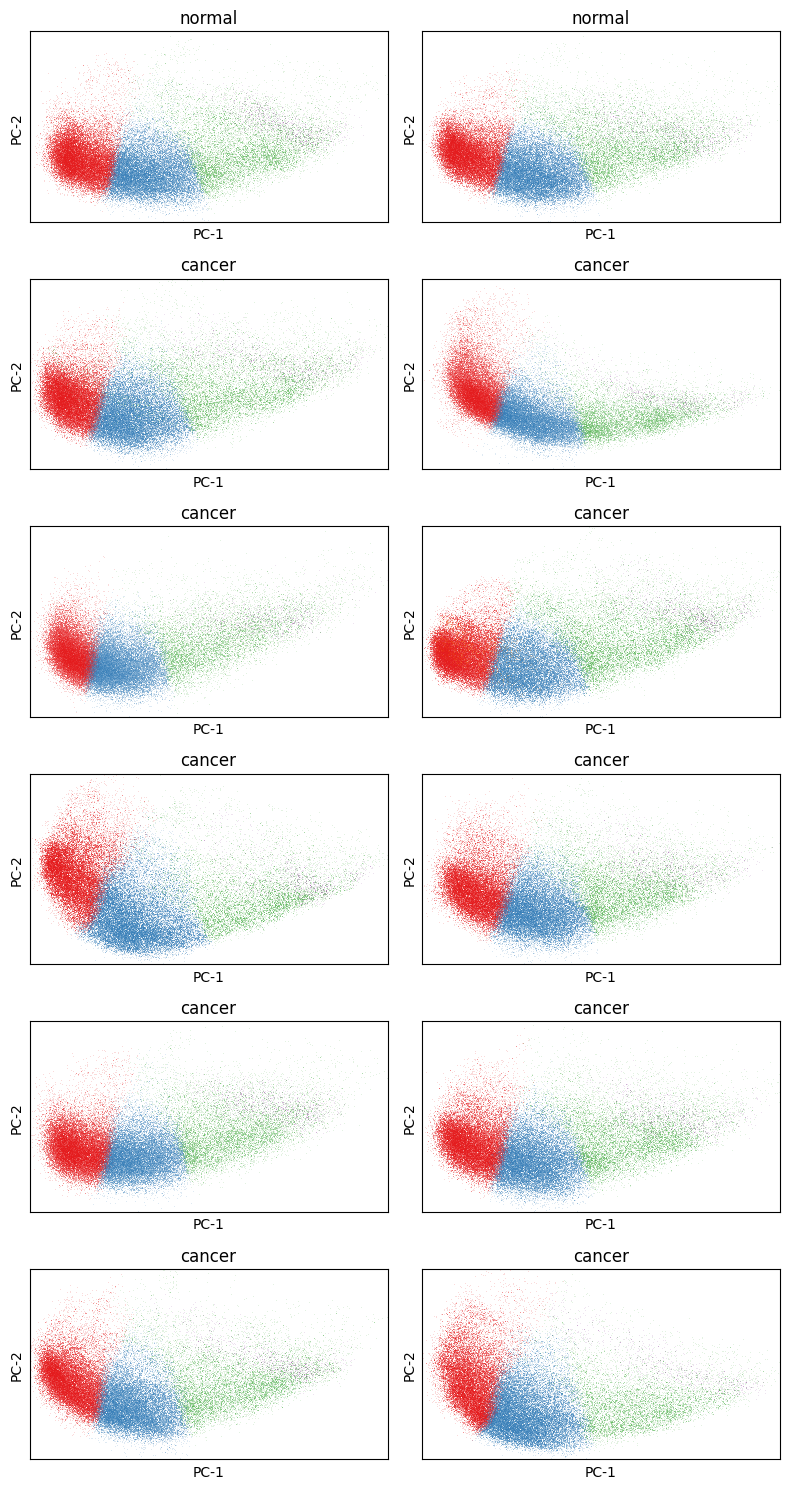

In [16]:
# Plot PCA embeddings for each sample, colored by leiden_0_5_n500 clusters
# There are 12 samples so let's organize them as nrows=6, ncols=2
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(8, 15))
axes = axes.flatten()

for i, row in db.experiment_metadata.iterrows():
    acc = row["accession"]
    biosample = row["biosample"]
    ax = axes[i]

    # Query DB for data for this accession & embeddings
    embeddings = db.get_embeddings(
        embeddings=["PCA1", "PCA2", "leiden_0_3_n500"],
        accessions=[acc],
        drop_bad_bins=True,
    )

    # Convert "leiden_0_3_n500" to category & store as "cluster"
    embeddings["cluster"] = embeddings["leiden_0_3_n500"].astype("category")
    im = dsshow(
        embeddings,
        ds.Point("PCA1", "PCA2"),
        aggregator=ds.count_cat("cluster"),
        aspect="auto",
        ax=ax,
    )
    ax.set_title(biosample)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("PC-1")
    ax.set_ylabel("PC-2")


plt.savefig("PCA-embeddings-clustered.pdf", dpi=300)
plt.tight_layout()
plt.show()

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 19 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'M', 'P', 'U', 'a', 'c', 'e', 'hyphen', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'r', 'space', 'two']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 36, 48, 51, 56, 68, 70, 72, 79, 80, 81, 82, 85]
INFO:fontTools.subset:Closed glyph list over 'MATH': 19 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'M', 'P', 'U', 'a', 'c', 'e', 'hyphen', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'r', 'space', 'two']
INFO:fontTools.subset:Glyph IDs:   [0, 1,

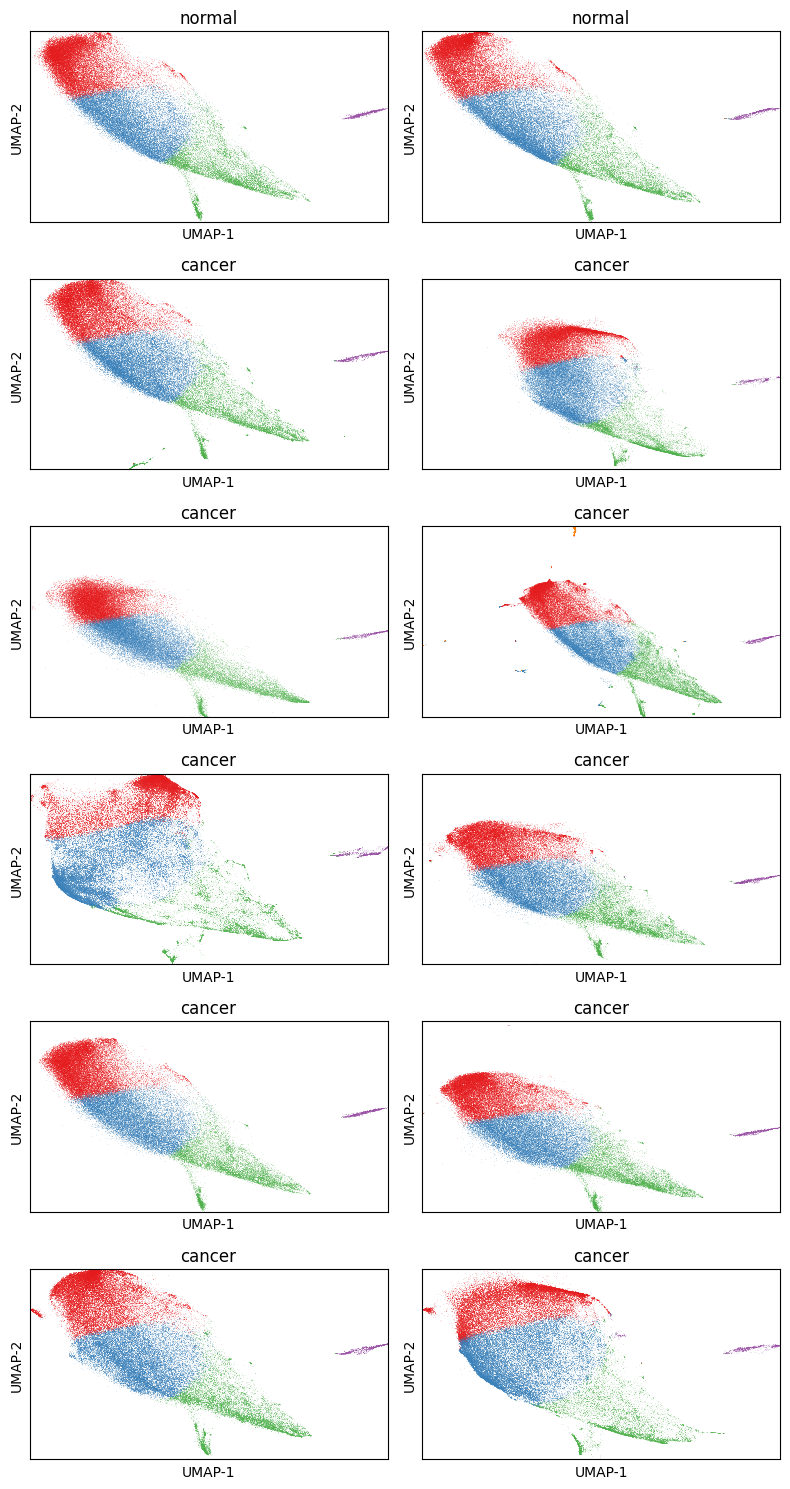

In [17]:
# Plot UMAP embeddings for each sample, colored by leiden_0_5_n500 clusters
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(8, 15))
axes = axes.flatten()

for i, row in db.experiment_metadata.iterrows():
    acc = row["accession"]
    biosample = row["biosample"]
    ax = axes[i]

    # Query DB for data for this accession & embeddings
    embeddings = db.get_embeddings(
        embeddings=["umap1_n100", "umap2_n100", "leiden_0_3_n500"],
        accessions=[acc],
        drop_bad_bins=True,
    )

    # Convert "leiden_0_3_n500" to category & store as "cluster"
    embeddings["cluster"] = embeddings["leiden_0_3_n500"].astype("category")
    im = dsshow(
        embeddings,
        ds.Point("umap1_n100", "umap2_n100"),
        aggregator=ds.count_cat("cluster"),
        aspect="auto",
        ax=ax,
    )
    ax.set_title(biosample)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")

plt.savefig("UMAP-embeddings-clustered.pdf", dpi=300)
plt.tight_layout()
plt.show()

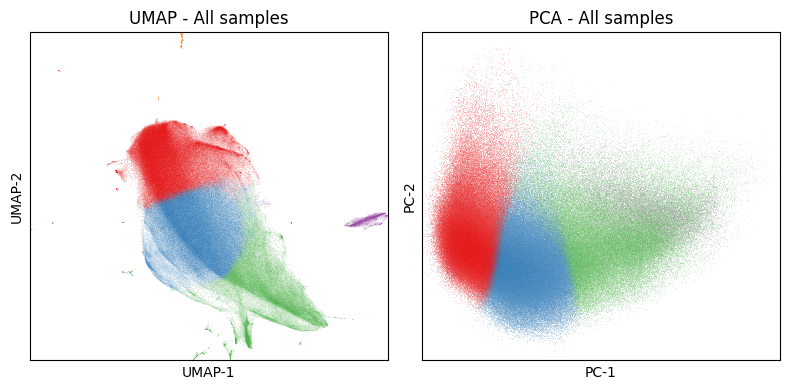

In [10]:
# Plot UMAP & PCA for all samples in one plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Query DB for data for this accession & embeddings
embeddings = db.get_embeddings(
    embeddings=["umap1_n100", "umap2_n100", "PCA1", "PCA2", "leiden_0_3_n500"],
    drop_bad_bins=True,
)

# Convert "leiden_0_3_n500" to category & store as "cluster"
embeddings["cluster"] = embeddings["leiden_0_3_n500"].astype("category")

# Plot UMAP
im = dsshow(
    embeddings,
    ds.Point("umap1_n100", "umap2_n100"),
    aggregator=ds.count_cat("cluster"),
    aspect="auto",
    ax=axes[0],
)
axes[0].set_title("UMAP - All samples")
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")

# Plot PCA
im = dsshow(
    embeddings,
    ds.Point("PCA1", "PCA2"),
    aggregator=ds.count_cat("cluster"),
    aspect="auto",
    ax=axes[1],
)
axes[1].set_title("PCA - All samples")
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel("PC-1")
axes[1].set_ylabel("PC-2")

plt.savefig("UMAP-PCA-all-samples.pdf", dpi=300)
plt.tight_layout()
plt.show()




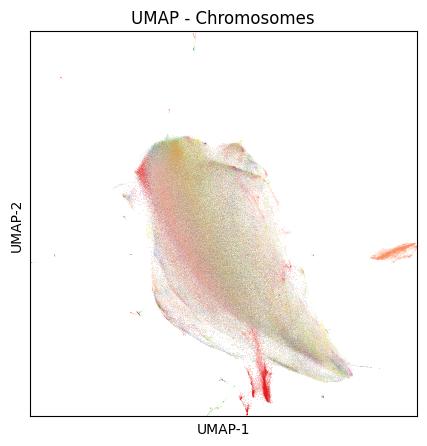

In [19]:
# The "stranded" aspect of the UMAP might be expalained by chromosome separation
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

# Filter to numerical chroms 1-22
embeddings = embeddings[
    embeddings["chrom"].isin([f"chr{i+1}" for i in range(22)])
].copy()

# Convert "chrom" to category & store as "chrom_cat"
embeddings["chrom_cat"] = embeddings["chrom"].astype("category")

# Plot UMAP
im = dsshow(
    embeddings,
    ds.Point("umap1_n100", "umap2_n100"),
    aggregator=ds.count_cat("chrom_cat"),
    aspect="auto",
    ax=axis,
)
axis.set_title("UMAP - Chromosomes")
axis.set_xticks([])
axis.set_yticks([])
axis.set_xlabel("UMAP-1")
axis.set_ylabel("UMAP-2")
plt.show()

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'O', 'P', 'R', 'S', 'T', 'U', 'X', 'Z', 'a', 'c', 'e', 'eight', 'five', 'four', 'h', 'm', 'nonmarkingreturn', 'one', 'period', 'seven', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 26, 27, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 51, 53, 54, 55, 56, 59, 61, 68, 70, 72, 75, 80]
INFO:fontTools.subset:Closed glyph list over 'MATH': 38 glyphs after
INFO:fontTools.sub

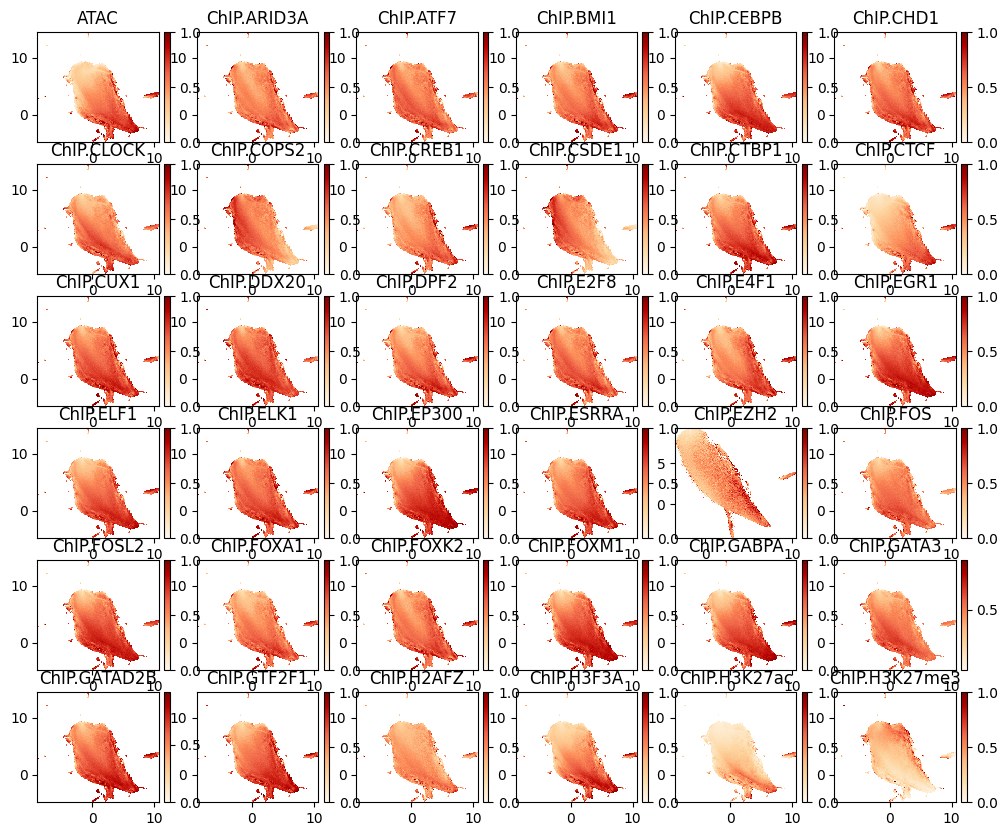

In [25]:
# Plot targets overlays
# Join ENCODE breast tissue metadata tracks to Hi-C embeddings on "biosample" and scale signal (clip & scale for each track)
# Plot overlays for all targets


def scale_signal(df) -> pd.DataFrame:
    """
    Scale the signal data in a DataFrame by clipping outliers at the 0.05 and 0.95 quantiles,
    then normalizing to the [0, 1] range.

    Args:
        df (pd.DataFrame): DataFrame containing signal data to be scaled.

    Returns:
        pd.DataFrame: DataFrame with scaled signal data.
    """

    def clip_and_scale(x):
        lower = x.quantile(0.05)
        upper = x.quantile(0.95)
        x_clipped = x.clip(lower=lower, upper=upper)
        return (x_clipped - lower) / (upper - lower)

    df["signal"] = df.groupby("bw_accession")["signal"].transform(clip_and_scale)
    return df


# List of ChIP-seq targets
targets = db.track_metadata.assay.unique()
targets.sort()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(12, 10))
axes = axes.flatten()

# Iterate over assays and axes
for ax, target in zip(axes, targets):
    # Gather ChIP-seq data for the specified target and apply the scaler
    umap_overlay = db.get_track_overlay(
        target, ["umap1_n100", "umap2_n100"], drop_bad_bins=True, scaler=scale_signal
    )

    # Plot the data using Datashader
    im = dsshow(
        umap_overlay,
        ds.Point("umap1_n100", "umap2_n100"),
        aggregator=ds.mean("signal"),
        aspect="auto",
        cmap="OrRd",
        ax=ax,
    )

    # Place a colorbar for each subplot
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 0.5, 1])

    ax.set_title(target)
    axis.set_xticks([])
    axis.set_yticks([])

plt.savefig("UMAP-overlays.pdf", dpi=300)
plt.show()

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 29 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'K', 'L', 'M', 'O', 'P', 'R', 'S', 'T', 'five', 'h', 'minus', 'nonmarkingreturn', 'one', 'period', 'seven', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 24, 26, 36, 37, 38, 39, 40, 41, 43, 44, 46, 47, 48, 50, 51, 53, 54, 55, 75, 3228]
INFO:fontTools.subset:Closed glyph list over 'MATH': 29 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'K',

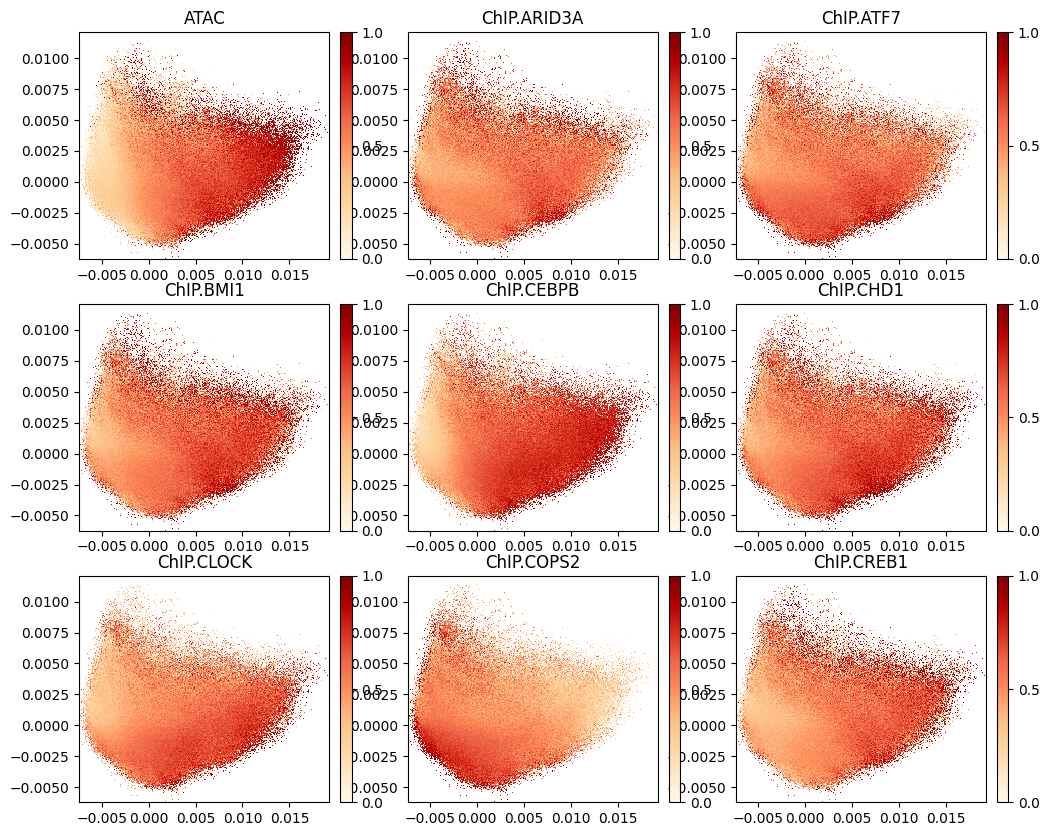

In [26]:
# Plot targets overlays
# Join ENCODE breast tissue metadata tracks to Hi-C embeddings on "biosample" and scale signal (clip & scale for each track)
# Plot overlays for all targets

# List of targets
targets = db.track_metadata.assay.unique()
targets.sort()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
axes = axes.flatten()

# Iterate over assays and axes
for ax, target in zip(axes, targets):
    # Gather ChIP-seq data for the specified target and apply the scaler
    overlay = db.get_track_overlay(
        target, ["PCA1", "PCA2"], drop_bad_bins=True, scaler=scale_signal
    )

    # Plot the data using Datashader
    im = dsshow(
        overlay,
        ds.Point("PCA1", "PCA2"),
        aggregator=ds.mean("signal"),
        aspect="auto",
        cmap="OrRd",
        ax=ax,
    )

    # Place a colorbar for each subplot
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 0.5, 1])

    ax.set_title(target)
    axis.set_xticks([])
    axis.set_yticks([])

plt.savefig("PCA-overlays.pdf", dpi=300)
plt.show()

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 22 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'P', 'e', 'eight', 'five', 'h', 'hyphen', 'i', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'space', 't', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 24, 27, 38, 51, 72, 75, 76, 81, 82, 85, 86, 87, 3228]
INFO:fontTools.subset:Closed glyph list over 'MATH': 22 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'P', 'e', 'eight', 'five', 'h', 'hyphen', 'i', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'period'

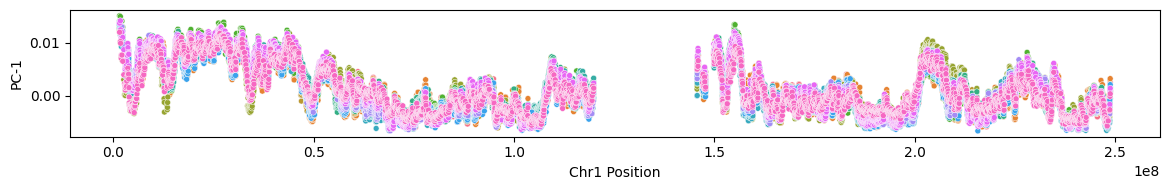

In [27]:
# Plot "Genome Browser" tracks for chr1
embeddings = db.get_embeddings(embeddings=["PCA1"], drop_bad_bins=False)
embeddings = embeddings[embeddings["chrom"] == "chr1"].copy()

fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(12, 2))
sns.scatterplot(
    data=embeddings, x="start", y="PCA1", size=1, hue="accession", ax=axis, legend=None
)

axis.set_xlabel("Chr1 Position")
axis.set_ylabel("PC-1")

plt.savefig("PC1-chr1-track-view.pdf", dpi=300)
plt.tight_layout()
plt.show()

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 25 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'H', 'K', 'P', 'e', 'eight', 'five', 'h', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 24, 26, 27, 38, 43, 46, 51, 72, 75, 76, 80, 81, 82, 85, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'MATH': 25 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'H', 'K', 'P', 'e', 'eight', 'five', 'h', 'i', 'm', 'n', 'nonmarkingreturn', 

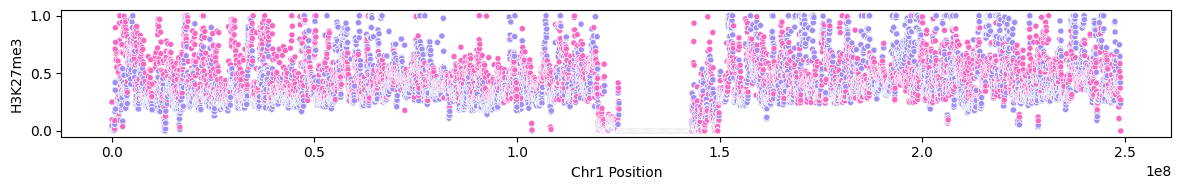

In [36]:
# Plot H3K27me3 signal along the same view
chip_signal = db.get_track_overlay(
    "ChIP.H3K27me3", ["PCA1"], drop_bad_bins=False, scaler=scale_signal
)

# Merge bin information
chip_signal = chip_signal.merge(db.bins)

# Filter to chr1
chip_signal = chip_signal[chip_signal["chrom"] == "chr1"]

fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(12, 2))
sns.scatterplot(
    data=chip_signal,
    x="start",
    y="signal",
    size=1,
    hue="accession",
    ax=axis,
    legend=None,
)

axis.set_xlabel("Chr1 Position")
axis.set_ylabel("H3K27me3")

plt.savefig("H3K27me3-chr1-track-view.pdf", dpi=300)
plt.tight_layout()
plt.show()

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 37 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'H', 'K', 'M', 'P', 'S', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'period', 'r', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 37, 38, 43, 46, 48, 51, 54, 68, 70, 71, 72, 74, 76, 79, 80, 81, 82, 85, 3228]
INFO:fontTools.subset:Closed glyph list over 'MATH': 43 glyphs 

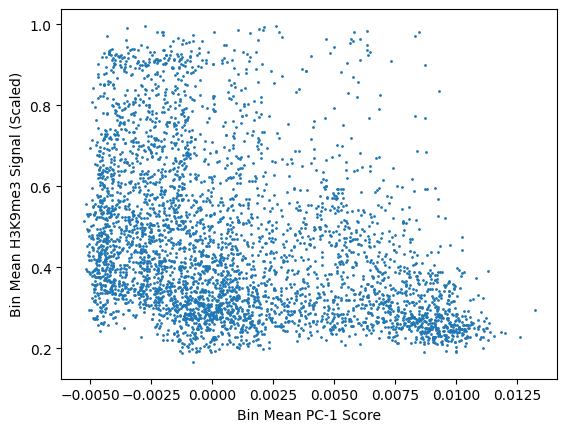

In [37]:
# Plot inverse relationship between PC-1 and H3K9me3 signal in chr1
plt.scatter(
    embeddings[["start", "PCA1"]].groupby("start").mean()["PCA1"],
    chip_signal[["start", "signal"]].groupby("start").mean()["signal"],
    s=1,
)

plt.xlabel("Bin Mean PC-1 Score")
plt.ylabel("Bin Mean H3K9me3 Signal (Scaled)")
plt.savefig("PC1-vs-H3K9me3-signal-chr1.pdf", dpi=300)
plt.show()